# Data Processing Pipeline

In [2]:
%reload_ext autoreload
%autoreload 2
import cudf
import cudf_tools as ct
import cudf_tools.cudf_flavor as cf
import cudf_tools.unit_methods
from kdephys.xr import xr_flavor_da, xr_flavor_ds
import kdephys.xr as kx
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from cudf_tools.unit_analysis import *
from kdephys.plot.main import *
from kdephys.plot.units import *
import yaml
import math
import acr
import tdt
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_t2/kdephys/kdephys/plot/acr_plots.mplstyle')
import ast
seq_len = 245760
fs = 24414.0625

In [7]:
subject = "ACR_16"

read from t=0s to t=666.06s
Using 152.5879 Hz as SEV sampling rate for EEG_
Using 152.5879 Hz as SEV sampling rate for LFP_
Using 152.5879 Hz as SEV sampling rate for LFPo
Using 24414.0625 Hz as SEV sampling rate for NNXo
Using 1017.2526 Hz as SEV sampling rate for EEGr
Using 1017.2526 Hz as SEV sampling rate for EMGr
Using 24414.0625 Hz as SEV sampling rate for NNXr
streams for sdpi-bl are ['NRe2', 'NRe3', 'EEG_', 'LFP_', 'LFPo', 'NNXo', 'EEGr', 'EMGr', 'NNXr', 'Wavt']
using ['NNXr', 'NNXo'] to get end times for sdpi-bl
read from t=86251s to t=86281.81s
Using 24414.0625 Hz as SEV sampling rate for NNXo
Using 24414.0625 Hz as SEV sampling rate for NNXr
read from t=0s to t=675.28s
Using 152.5879 Hz as SEV sampling rate for EEG_
Using 152.5879 Hz as SEV sampling rate for LFP_
Using 152.5879 Hz as SEV sampling rate for LFPo
Using 24414.0625 Hz as SEV sampling rate for NNXo
Using 1017.2526 Hz as SEV sampling rate for EEGr
Using 1017.2526 Hz as SEV sampling rate for EMGr
Using 24414.0625 Hz

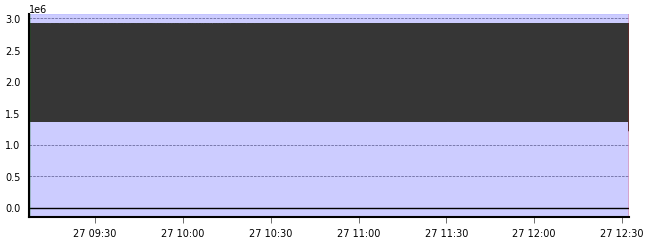

In [5]:
acr.info_pipeline.update_subject_info('ACR_16')

# Functions

In [4]:
def find_all_duplicate_start_indexes(data, seq_len=245760):
    starts = []
    for i in range(0, len(data), 50):
        a1 = data[i:i+49]
        a2 = data[i+seq_len:i+seq_len+49]
        if len(a1) != len(a2):
            return np.array(starts)
        if all(a1 == a2):
            for bk in range(51):
                v1 = data[i-bk]
                v2 = data[i+seq_len-bk]
                if v1 == v2:
                    continue
                else:
                    starts.append( i-bk+1 )
                    break
    return np.array(starts)

def find_duplicate_end_index(start_index, data, seq_len=245760):
    scan = len(data) - start_index
    for i in range(scan-1):
        if data[start_index+i] != data[start_index+seq_len+i]:
            return start_index+(i-1)
    return None

def plot_duplicate(data, s, e, ds, de):
    f, ax = plt.subplots()
    dup_len = len(data[s:e+1])
    dup_spacing = ds-s
    d1 = data[s-dup_len:e+dup_len]
    d2 = data[ds-dup_len:de+dup_len]
    if len(d1) != len(d2):
        d1 = data[s-dup_len:e+1]
        d2 = data[ds-dup_len:de+1]
    tix = np.arange(0, len(d1))
    ax.plot(tix, d1, color='darkgreen')
    ax.plot(tix, d2, color='blue', alpha=0.6)
    ax.axvspan(dup_len, dup_len+dup_len, color='red', alpha=0.2)
    
    return f, ax, dup_len

def check_end_times_yaml(subject, rec, store):
    end_info = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/end_times.yaml', 'r'))
    if subject in end_info.keys():
        if rec in end_info[subject].keys():
            if store in end_info[subject][rec].keys():
                if 'zero_period_start' in end_info[subject][rec][store].keys():
                    return True
    return False

def check_dup_info_yaml(subject, rec, store):
    dup_info = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/duplication_info.yaml', 'r'))
    if subject in dup_info.keys():
        if rec in dup_info[subject].keys():
            if store in dup_info[subject][rec].keys():
                if 'ends' and 'starts' in dup_info[subject][rec][store].keys():
                    return True
    return False

def search_for_zero_period(data, fs=24414.0625):
    for i in range(0, len(data), 500):
        a1 = data[i:i+500]
        if all(a1 == 0):
            start = int(i/fs)
            return [start]
    return [0]

# Complete End-Time (zero-period) Pipeline

In [6]:
# Complete Pipeline to Check for any zero-periods in the data (any chunks of consistent 0's)
important_recs = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/important_recs.yaml', 'r'))
end_info = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/end_times.yaml', 'r'))

for subject in important_recs.keys():
    si = acr.info_pipeline.load_subject_info(subject)
    stores = important_recs[subject]['stores']
    for exp in important_recs[subject]:
        if exp == 'stores':
            continue
        for rec in important_recs[subject][exp]:
            for store in stores:
                print(f'Checking {subject} {rec} {store} for duplicates')
                #check if already searched for duplicates
                if check_end_times_yaml(subject, rec, store):
                    print(f'Already checked {subject} {rec} {store}, skipping')
                    continue
            
                #Load the data
                print(f'loading {subject} {rec} {store}')
                data = tdt.read_block(si['paths'][rec], store=store, channel=14, t1=0, t2=0)
                data = data.streams[store].data
                
                #search for zero-periods
                zero_period_start = search_for_zero_period(data)

                # update that start time in the yaml file
                if subject not in end_info.keys():
                    end_info[subject] = {}
                if rec not in end_info[subject].keys():
                    end_info[subject][rec] = {}
                if store not in end_info[subject][rec].keys():
                    end_info[subject][rec][store] = {}
                end_info[subject][rec][store]['zero_period_start'] = zero_period_start
                with open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/end_times.yaml', 'w') as f:
                    yaml.dump(end_info, f)

Checking ACR_9 control1 NNXr for duplicates
Already checked ACR_9 control1 NNXr, skipping
Checking ACR_9 laser1 NNXr for duplicates
Already checked ACR_9 laser1 NNXr, skipping
Checking ACR_12 control1-bl NNXr for duplicates
Already checked ACR_12 control1-bl NNXr, skipping
Checking ACR_12 control1 NNXr for duplicates
Already checked ACR_12 control1 NNXr, skipping
Checking ACR_12 laser1-bl NNXr for duplicates
Already checked ACR_12 laser1-bl NNXr, skipping
Checking ACR_12 laser1 NNXr for duplicates
Already checked ACR_12 laser1 NNXr, skipping
Checking ACR_13 laser1-bl NNXr for duplicates
Already checked ACR_13 laser1-bl NNXr, skipping
Checking ACR_13 laser1-bl NNXo for duplicates
Already checked ACR_13 laser1-bl NNXo, skipping
Checking ACR_13 laser1 NNXr for duplicates
Already checked ACR_13 laser1 NNXr, skipping
Checking ACR_13 laser1 NNXo for duplicates
Already checked ACR_13 laser1 NNXo, skipping
Checking ACR_13 laser1-post1 NNXr for duplicates
Already checked ACR_13 laser1-post1 NNX

# Complete Duplicate Checker Pipeline

In [12]:
# Complete Pipeline to Check for all duplicates spaced by 245760 samples
dup_info = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/duplication_info.yaml', 'r'))
important_recs = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/important_recs.yaml', 'r'))
end_info = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/end_times.yaml', 'r'))

for subject in important_recs.keys():
    si = acr.info_pipeline.load_subject_info(subject)
    stores = important_recs[subject]['stores']
    for exp in important_recs[subject]:
        if exp == 'stores':
            continue
        for rec in important_recs[subject][exp]:
            for store in stores:
                print(f'Checking {subject} {rec} {store} for duplicates')
                #check if already searched for duplicates
                if check_dup_info_yaml(subject, rec, store):
                    print(f'Already checked {subject} {rec} {store}, skipping')
                    continue

                #check if there is a zero-period to avoid
                end_time = end_info[subject][rec][store]['zero_period_start'][0]
                if type(end_time) == int:
                    t2 = end_time
                else:
                    t2 = 0
                if t2 == 174:
                    t2 = 0
                print('t2, ', t2)
                #Load the data, find start and end indexes of duplicates
                data = tdt.read_block(si['paths'][rec], store=store, channel=14, t1=0, t2=t2)
                data = data.streams[store].data
                starts = find_all_duplicate_start_indexes(data)
                ends = []
                for s in starts:
                    e = find_duplicate_end_index(s, data)
                    if e is not None:
                        ends.append(e)
                ends = np.array(ends)
                dup_starts = starts + seq_len
                dup_ends = ends + seq_len
                #Plot the duplicates
                for i in range(len(starts)):
                    f, ax, dup_len = plot_duplicate(data, starts[i], ends[i], dup_starts[i], dup_ends[i])
                    ax.set_title(f'{subject} | {rec} | {store} | Duplicate {i+1}/{len(starts)} | {dup_len} samples | Start Time = {starts[i]/24414.0625} s')
                    plt.savefig(f'/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/data_duplication_figures/{subject}--{rec}--{store}__duplicate{i+1}.png')
                    plt.close('all')
                
                #Save the start and end indexes of the duplicates to yaml file
                if subject not in dup_info.keys():
                    dup_info[subject] = {}
                if rec not in dup_info[subject].keys():
                    dup_info[subject][rec] = {}
                if store not in dup_info[subject][rec].keys():
                    dup_info[subject][rec][store] = {}
                dup_info[subject][rec][store]['starts'] = starts.tolist()
                dup_info[subject][rec][store]['ends'] = ends.tolist()
                with open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/duplication_info.yaml', 'w') as f:
                    yaml.dump(dup_info, f)

Checking ACR_9 control1 NNXr for duplicates
Already checked ACR_9 control1 NNXr, skipping
Checking ACR_9 laser1 NNXr for duplicates
Already checked ACR_9 laser1 NNXr, skipping
Checking ACR_12 control1-bl NNXr for duplicates
Already checked ACR_12 control1-bl NNXr, skipping
Checking ACR_12 control1 NNXr for duplicates
Already checked ACR_12 control1 NNXr, skipping
Checking ACR_12 laser1-bl NNXr for duplicates
Already checked ACR_12 laser1-bl NNXr, skipping
Checking ACR_12 laser1 NNXr for duplicates
Already checked ACR_12 laser1 NNXr, skipping
Checking ACR_13 laser1-bl NNXr for duplicates
Already checked ACR_13 laser1-bl NNXr, skipping
Checking ACR_13 laser1-bl NNXo for duplicates
Already checked ACR_13 laser1-bl NNXo, skipping
Checking ACR_13 laser1 NNXr for duplicates
Already checked ACR_13 laser1 NNXr, skipping
Checking ACR_13 laser1 NNXo for duplicates
Already checked ACR_13 laser1 NNXo, skipping
Checking ACR_13 laser1-post1 NNXr for duplicates
Already checked ACR_13 laser1-post1 NNX

# Master Recording Quality Spreadsheet

In [9]:
def check_rec_quality_sheet(subject, rec, store):
    rec_quality = pd.read_excel('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/master_rec_quality.xlsx')
    sub = rec_quality.loc[rec_quality['subject'] == subject]
    if sub.empty:
        return False
    sub_recs = sub.loc[sub['recording'] == rec]
    if sub_recs.empty:
        return False
    sub_recs_stores = sub_recs.loc[sub_recs['store'] == store]
    if sub_recs_stores.empty:
        return False
    return True

In [17]:
# complete pipeline to update the master_rec_quality excel sheet
recq_path = '/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/master_rec_quality.xlsx'
rec_quality = pd.read_excel(recq_path)
dup_info = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/duplication_info.yaml', 'r'))
important_recs = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/important_recs.yaml', 'r'))
end_info = yaml.safe_load(open('/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/end_times.yaml', 'r'))

dic_list = []
for subject in important_recs.keys():
    si = acr.info_pipeline.load_subject_info(subject)
    stores = important_recs[subject]['stores']
    for exp in important_recs[subject]:
        if exp == 'stores':
            continue
        for rec in important_recs[subject][exp]:
            for store in stores:
                #check if info already in rec_quality sheet
                if check_rec_quality_sheet(subject, rec, store):
                    continue
                print(f'Adding {subject} {rec} {store} to rec_quality sheet')
                end_time = end_info[subject][rec][store]['zero_period_start'][0]
                duplicate = dup_info[subject][rec][store]['starts']
                if duplicate == []:
                    duplicate = 'No'
                else:
                    duplicate = len(duplicate)
                dic = {'subject':subject, 'recording':rec, 'store':store, 'end_time':end_time, 'duplicate_found':duplicate, 'duplicates_corrected':'', 'notes':''}
                dic_list.append(dic)
df = pd.DataFrame.from_records(dic_list)
if df.empty:
    print('No new entries to add to rec_quality sheet')
else:
    df.loc[df.duplicate_found != 'No', 'duplicates_corrected'] = 'No'
    new_rec_quality = pd.concat([rec_quality, df], ignore_index=True)
    new_rec_quality.to_excel(recq_path, index=False)

Adding ACR_16 sdpi-bl NNXr to rec_quality sheet
